# Case study: Magnetization experiment

We continue with the same case study as in the previous lesson and start with the same model. In the previous lesson, we found some problems with the model. We attempt to improve on the model here.

**Suggestion:** Click the _Run All Cells_ button. This will save you some time by running the slow PyMC code while you are reading.

## Prep plan

* There are no required readings for this pre-class work.
* Spend all your prep time on this workbook, especially understanding the PyMC diagnostic output in detail.

## Data

**Run the code cells below** to get started by loading the data and creating and fitting the simple model from the previous lesson.

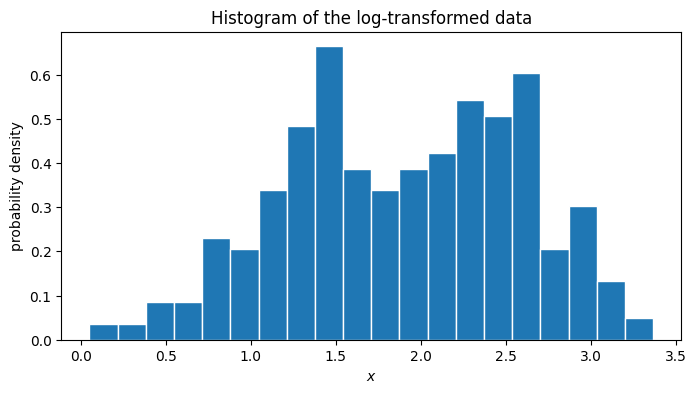

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt


# Load data: read the particle sizes (in nanometers) from a CSV file.
data = np.loadtxt('hrtem.csv')

# Log-transform the data
data = np.log(data)

# Plot the data
plt.figure(figsize=(8, 4))
plt.title('Histogram of the log-transformed data')
plt.xlabel('$x$')
plt.ylabel('probability density')
plt.hist(data, bins=20, density=True, edgecolor='white')
plt.show()

## Model

From the previous lesson:

$$m, s^2\sim\text{Normal-Inverse-Gamma}(\mu_0, \nu_0, \alpha_0, \beta_0)$$

$$x_i\sim\text{Normal}(m, s^2) \quad\text{i.i.d. for all } i$$

with $\mu_0 = 2.3$, $\nu_0 = 11$, $\alpha_0 = 9.563$, $\beta_0 = 23.547$.

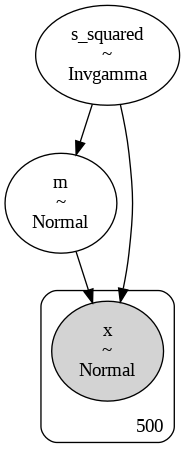

In [2]:
import pymc as pm

# Prior Normal-Inverse-Gamma parameters
mu_0 = 2.3
nu_0 = 11
alpha_0 = 9.563
beta_0 = 23.547

# Model specification
with pm.Model() as model:
    s_squared = pm.InverseGamma('s_squared', alpha=alpha_0, beta=beta_0)
    m = pm.Normal('m', mu=mu_0, sigma=np.sqrt(s_squared / nu_0))
    pm.Normal('x', mu=m, sigma=np.sqrt(s_squared), observed=data)

from IPython.display import Image
Image(pm.model_to_graphviz(model).render(format='png'))

## Fit the model

This code cell will take a minute or so to run.

In [3]:
with model:
    inference = pm.sample()

Output()

## Plot samples from the posterior-predictive

**Run this cell** and observe that the gap between the blue histogram and the orange curves in the middle of the last plot doesn’t look right. Furthermore, the right tails of the posterior samples look too heavy for the data.

This indicates that we could improve our model by using a different likelihood function — one that allows for more than one peak in the data distribution.

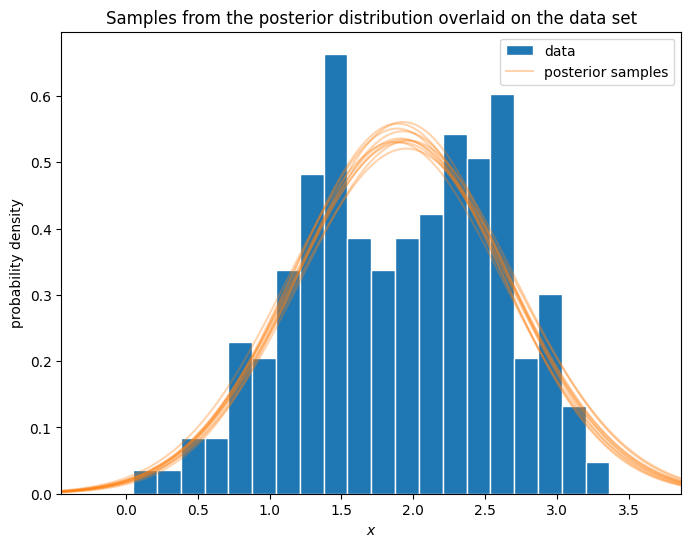

In [4]:
posterior_m = inference.posterior.m.values.flatten()
posterior_s_squared = inference.posterior.s_squared.values.flatten()

plot_x = np.linspace(min(data) - 0.5, max(data) + 0.5, 500)
plt.figure(figsize=(8, 6))
plt.hist(data, bins=20, density=True, edgecolor='white', label='data')
plt.title('Samples from the posterior distribution overlaid on the data set')
plt.xlabel('$x$')
plt.ylabel('probability density')
for i in range(10):
    plot_y = sts.norm.pdf(
        plot_x, loc=posterior_m[i], scale=np.sqrt(posterior_s_squared[i]))
    plt.plot(
        plot_x, plot_y, color='C1', alpha=1/3,
        label='posterior samples' if i == 0 else None)
plt.xlim(plot_x[0], plot_x[-1])
plt.legend()
plt.show()

## Diagnostic output from PyMC

Before we proceed to a new model, we take a short detour into _computational diagnostics_. One of the things that can go wrong with any approximate inference algorithm is that the algorithm doesn’t create a good approximation of the true posterior distribution. This is a computational problem rather than a modeling problem. Our model might be perfectly good, but if the inference algorithm can’t approximate the true posterior distribution, we will still get inaccurate or incorrect results. The purpose of computational diagnostics is to help us detect and correct computational problems (not modeling problems).

What we’ll see below is that the model we have so far is performing well computationally (so we really are getting samples from the true posterior distribution) even though it is performing poorly from a modeling perspective — that gap we identified in the last plot is there because our model doesn’t fit the data well.

Spoiler: When we try our new, improved model below, we’ll have the reverse situation. Even though it’s a better model, we’ll have computational problems. Today’s goal is to identify and resolve these computational problems.

### Diagnostic 1: Sampling summary statistics

[ArviZ](https://python.arviz.org/) is a Python library for analyzing inference in Bayesian models. Today, we use it primarily to check whether the PyMC sampling algorithm succeeded or failed. ArviZ also has useful functions for visualizing posterior distributions — more on that below.

The first function we use is called `summary`. **Run this code cell.**

In [5]:
import arviz as az

az.summary(inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,1.902,0.033,1.840,1.962,0.001,0.001,1647.0,1208.0,1.01
s_squared,0.555,0.035,0.489,0.620,0.001,0.001,1783.0,1523.0,1.00


The sampling summary statistics provide a quick overview of what happened in the chains of samples, called _Markov chains_, generated by the NUTS algorithm. (We’ll learn more about Markov chains later in the course.) The summary displays information about the posterior distributions over all the model parameters as well as statistics that reflect the quality of the Markov chains.

What we’re mainly looking for today is whether or not the Markov chains are of high quality. Let’s go through what you do and do not want to see in the summary statistics. Start on the right-hand side of the table above.

1. We want an `r_hat` ($\hat R$) value that is very close to 1. A value like 1.01 is probably still okay. Anything greater than 1.01 is probably not okay. A value like 1.1 is far too large. Later in the course, when we learn more about how MCMC sampling algorithms work, we will discuss $\hat{R}$ in some detail. If you want to read ahead, here is [a very informative and only somewhat technical blog post](https://statmodeling.stat.columbia.edu/2019/03/19/maybe-its-time-to-let-the-old-ways-die-or-we-broke-r-hat-so-now-we-have-to-fix-it/) (2630 words) that is a fun read. (Most articles about $\hat{R}$ are _really_ technical.)

2. Next are the two ESS (effective sample size) columns. We want these values to be large — at least a few hundred. We know the sampling algorithm generates samples and we know how many, namely 2000 in this workbook. What we don’t know is to what extent those samples are uncorrelated. They are definitely _not_ independent since Markov chains are, well, chains — the next state in a Markov chain depends on the previous state. A good sampling algorithm works hard to ensure consecutive samples are uncorrelated with each other. The effective sample size is a measure of how successful this was. For now, note that these values should be at least 200 if we’re generating 2000 samples, as a rule of thumb. The sampler will usually do much better than that but if we see a value less than 1/10 of the actual number of samples, we’re probably in trouble.

We’ll focus on these two diagnostic statistics for now and largely ignore the others, which are statistics about the posterior distribution. For completeness, they are
* `mean`: the sample mean of the parameter
* `sd`: the sample standard deviation of the parameter
* `hdi_3%`, `hdi_97%`: the left and right boundaries of the 94% highest density interval of the distribution
* `mcse_mean`, `mcse_sd`: the Monte Carlo standard error in the mean and standard deviation of this parameter. The MCSE is an estimate of how much numerical (sampling) error there is in the estimates in the `mean` and `sd` column. These errors increase if the expected sample size is low — that is, when there is high correlation in a Markov chain.

### Diagnostic 2: Rank plot

**Run this code cell** then, read on.

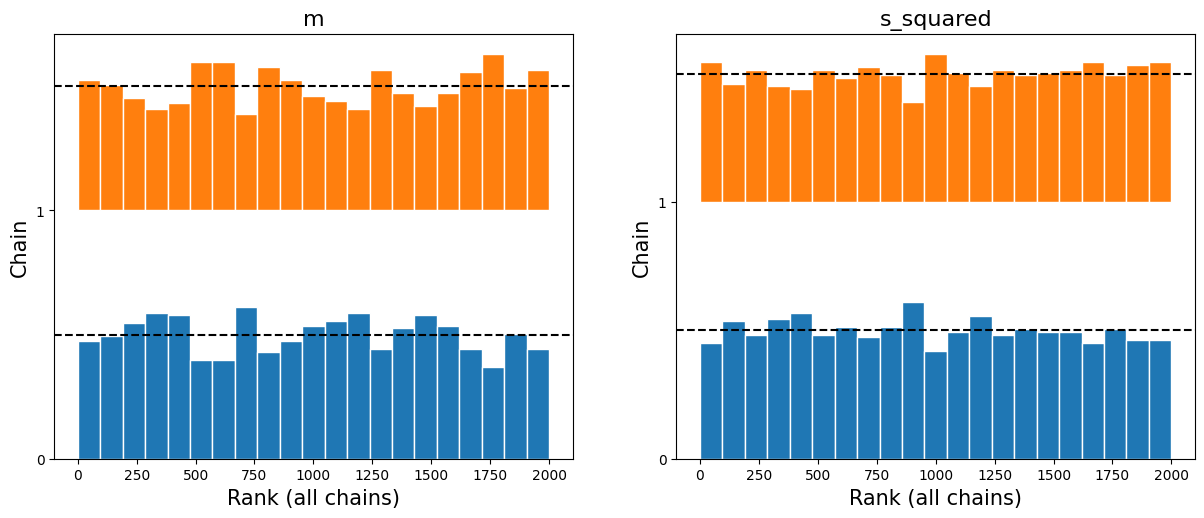

In [6]:
az.plot_rank(inference);

A rank plot shows us one histogram for each unobserved variable in the model and each chain in the sampler.

What we want our sampler to do is (a) explore the _whole_ posterior distribution, and (b) do so reliably — that is, if we restart the sampler from a different initial point, it should still sample the whole posterior like before.

Rank plots help us see whether or not that is happening. Each sampling chain starts at a different random location. If we take all the samples (across all chains) for a particular variable, sort them, and then histogram the rank (the sorted index/location) of the values, we should get a Uniform distribution for each chain. If a particular chain missed parts of the posterior that the other chain found, there would be a big block of values in the sorted list that came from a particular chain and we would see a peak in the histogram for that chain. (You will see an example of this behavior later in this workbook.) If all chains are randomly jumping around the whole posterior distribution, each sorted value should randomly come from one of the chains and therefore produce an approximately uniform histogram.

**Sidebar:** By default, PyMC runs one sampling chain for each computer core in your computer, with a minimum of 2 chains. My laptop has 4 cores, so I get 4 chains by default. Google Colab’s (virtual) computer has 1 core, so we get 2 chains by default. You can ask for more (or fewer) chains by using the `chains` argument in the `sample()` function — it will just take longer to run.

In the rank plot above, the histograms are all roughly uniform. The black dashed line shows us the height of a perfectly uniform distribution. The histogram bars we get are all a little above or below this line.

### Diagnostic 3: Pair plot

A pair plot basically shows the posterior distribution over all pairs of variables. In this model, we have only 2 variables and therefore only 1 pair but in larger models (we look at one below), there are many more pairs.

**Run this code cell** and read on.

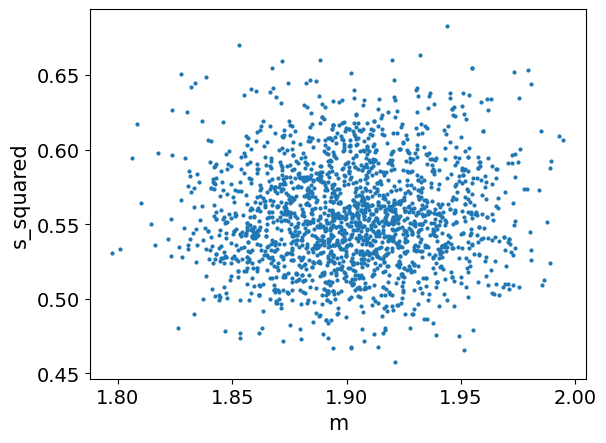

In [7]:
az.plot_pair(inference);

The plot shows all the samples the sampling algorithm generated from the posterior distribution. It might seem strange to call a plot of the posterior samples a diagnostic but it is important to look at a posterior distribution. Does it behave the way we expect it to? If not, is there something wrong with our expectations — should we better understand how the model behaves? — or is there something wrong with the sampling algorithm?

Don’t ever assume the algorithm is just working because sometimes it won’t be. Check the results and think carefully about whether or not they make sense.

To make the pair plot more informative, we can add the marginal distributions of the variables. **Run this code cell.**

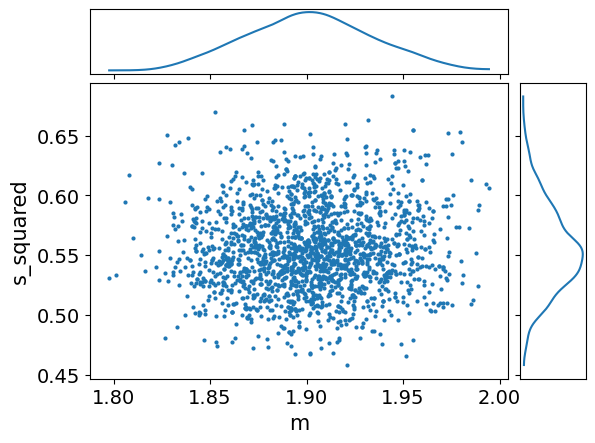

In [8]:
az.plot_pair(inference, marginals=True);

And we can also overlay a contour plot on the samples.

**Run the code cell below.**

The figure still shows us all the samples but also displays approximate level curves (contours) of the posterior probability density and the approximate marginal distribution over each of the variables in the model.

This posterior plot looks good. There is one peak (mode) showing the most likely values of $m$ and $s^2$ and a region of high probability around that peak which shows us the credible region of the two parameters. A final observation: the posterior seems to be independent in $m$ and $s^2$. Later, we will see correlated posteriors.

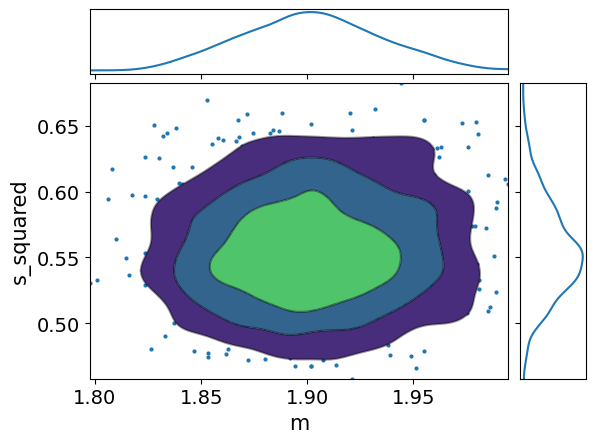

In [9]:
az.plot_pair(
    inference,
    marginals=True,
    kind=["scatter", "kde"],
    scatter_kwargs={"color": "C0", "alpha": 1},
    marginal_kwargs={"kind": "kde", "color": "C0"},
    kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 0.4}});

## Model 2: Mixture of Normals

In an attempt to improve our model, we fit a weighted sum of two Normal distributions. This type of model is often called a Gaussian Mixture Model.

Intuitively, a Gaussian mixture model looks like this:

$$w_1\,\text{Normal}_1 + w_2\,\text{Normal}_2 + \cdots + w_k\,\text{Normal}_k$$

The $w_i$ variables are _weights_ that add up to 1. (They have to add up to 1 so that the resulting probability distribution is still normalized.) Each Normal distribution has its own mean and variance.

A model like this can be appropriate if the data distribution is multimodal (i.e., has more than one peak). In this case, a unimodal distribution (i.e., with only one mode) like a Normal won’t fit well but a combination of unimodal distributions might fit well.

### Required video

Watch up to 9:20 of Miller, J.W. (2011, July 11). [Gaussian mixture model](https://www.youtube.com/watch?v=Rkl30Fr2S38). Youtube. This video visualizes what a mixture of Normal distributions looks like in two dimensions and shows how the PDF of the mixture model is constructed from a linear combination of Normal PDFs. The last 5 minutes of the video are optional, discussing how this type of model is often fit to data in the context of Machine Learning.

### Here is our model

We sample the first weight from a Uniform distribution on the interval $[0,1]$. Since we have only two components in our mixture model, the second weight is just 1 minus the first weight.

$$w\sim\text{Beta}(1,1)$$

We use a Normal prior over the mean of each mixture component and an Inverse-Gamma prior over the variance of each mixture component.

$$m_j\sim\text{Normal}(2.3, 0.5^2) \quad\text{for } j=1,2$$

$$s_j^2\sim\text{Inverse-Gamma}(1, 1) \quad\text{for } j=1,2$$

The data are generated from the mixture model defined by the Normals and weights above.

$$x_i\sim\text{Normal-Mixture}([w, 1-w], [m_1, m_2], [s_1^2, s_2^2]) \quad\text{i.i.d. for } i=1,2,\ldots,500$$

**Carefully read the code below** to see how the model above is implemented in PyMC.
* The `size=2` argument in the `Normal` and `InverseGamma` distributions below is new. This allows us to create a whole array of distributions (in this case, only 2) in a single line. These random variables are i.i.d.
* We pass a list (or array) of weights, means, and standard deviations to the `NormalMixture` distribution in PyMC.

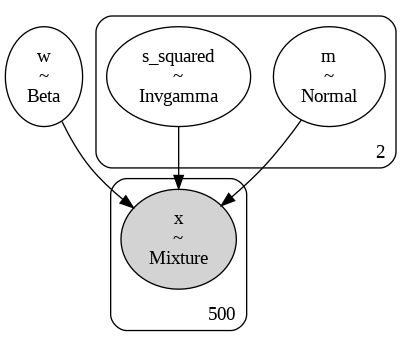

In [10]:
with pm.Model() as mixture_model:

    # Weight of the first mixture component
    w = pm.Beta('w', alpha=1, beta=1)

    # Means and variances of the mixture components
    m = pm.Normal('m', shape=2, mu=2.3, sigma=0.5) # there are two of them
    s_squared = pm.InverseGamma('s_squared', shape=2, alpha=1, beta=1) # two of them

    # Create the Normal mixture model with the given weights, means, and
    # standard deviations
    pm.NormalMixture(
        'x',
        w=[w, 1-w],
        mu=m,
        sigma=np.sqrt(s_squared),
        observed=data)

from IPython.display import Image
Image(pm.model_to_graphviz(mixture_model).render(format='png'))

### Prior-predictive

**Run this code cell** to plot some samples from the prior and prior-predictive distributions.

* The plots show the Normal mixture components as well as the resulting Normal-Mixture distribution.
* You should see that some of the mixtures still look unimodal (if the mixture components are similar) while others have heavy tails or are right or left-skewed.

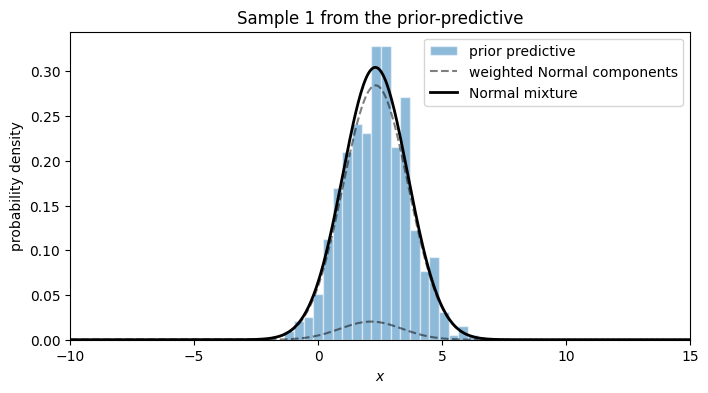

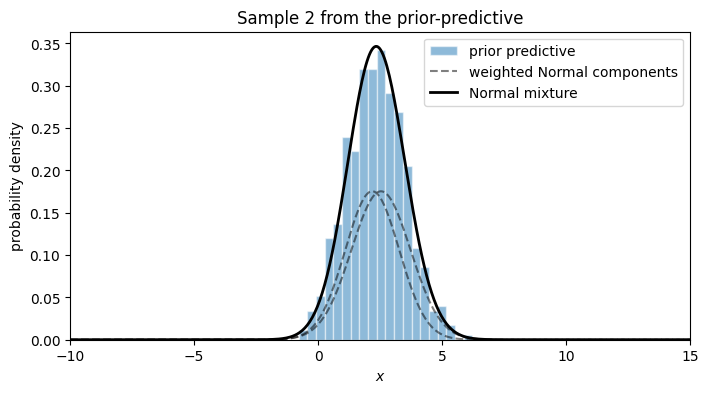

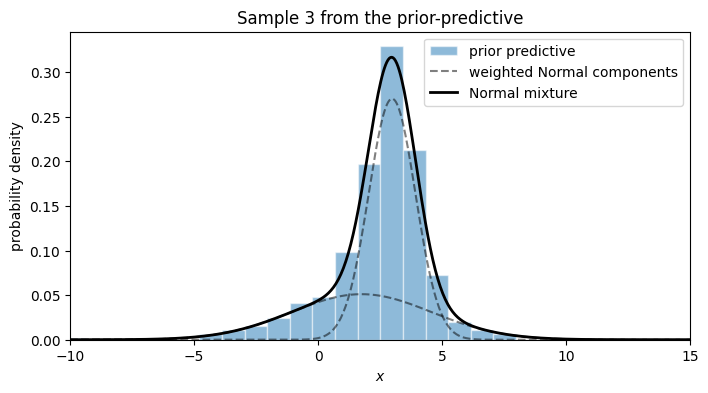

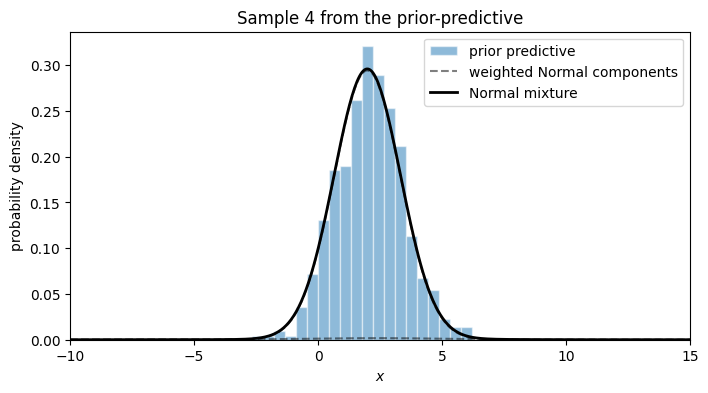

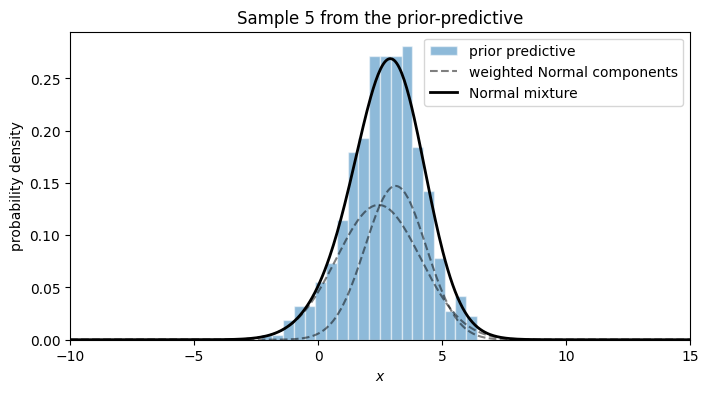

In [11]:
# Sample prior and prior-predictive
with mixture_model:
    inference = pm.sample_prior_predictive(random_seed=10)

# Visualize the samples
for i in range(5):

    # Extract values sampled from the prior and prior-predictive
    w = inference.prior.w.values[0, i]
    m = inference.prior.m.values[0, i, :]
    s_squared = inference.prior.s_squared.values[0, i, :]
    x = inference.prior_predictive.x.values[0, i, :]

    # Plot prior-predictive histogram and sampled likelihood function
    plt.figure(figsize=(8, 4))
    plt.title(
        f'Sample {i+1} from the prior-predictive')
    plt.xlabel('$x$')
    plt.ylabel('probability density')
    plt.hist(
        x, bins=20, density=True, label='prior predictive',
        edgecolor='white', alpha=0.5)

    plot_x = np.linspace(-10, 15, 500)
    normal_1 = sts.norm.pdf(plot_x, loc=m[0], scale=np.sqrt(s_squared[0]))
    normal_2 = sts.norm.pdf(plot_x, loc=m[1], scale=np.sqrt(s_squared[1]))
    plot_y = w * normal_1 + (1-w) * normal_2
    plt.plot(
        plot_x, w * normal_1, label='weighted Normal components',
        color='k', linestyle='--', alpha=0.5)
    plt.plot(plot_x, (1-w) * normal_2, color='k', alpha=0.5, linestyle='--')
    plt.plot(plot_x, plot_y, linewidth=2, color='k', label='Normal mixture')
    plt.xlim(-10, 15)
    plt.legend()

plt.show()

### Fit the model

In [28]:
with mixture_model:
    inference = pm.sample(chains=4, random_seed=314159)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Task: Check the diagnostics

From now on, we will _always_ produce the diagnostic output after fitting a model. It is best practice to make sure the computation was successful before visualizing the posterior or posterior-predictive distributions or drawing any conclusions from the posterior samples.

If the computation failed, the posterior samples are useless.

**Run this code cell for the summary**, consider what the output tells you (read the notes above about $\hat{R}$ and ESS again if necessary), and record your observations below.

In [29]:
az.summary(inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m[0],1.973,0.533,1.329,2.586,0.263,0.002,6.0,124.0,1.74
m[1],1.972,0.534,1.333,2.595,0.264,0.002,6.0,124.0,1.74
s_squared[0],0.203,0.074,0.098,0.336,0.031,0.002,6.0,108.0,1.70
s_squared[1],0.201,0.073,0.095,0.328,0.031,0.001,6.0,148.0,1.71
w,0.501,0.098,0.317,0.672,0.038,0.002,7.0,212.0,1.58


Record your observations. What does the summary output tell us about how well the sampler worked?

In [14]:
# ENTER YOUR OBSERVATIONS IN YOUR FORUM PRE-CLASS WORKBOOK

**Run this code cell for the rank plot** and record your observations below.

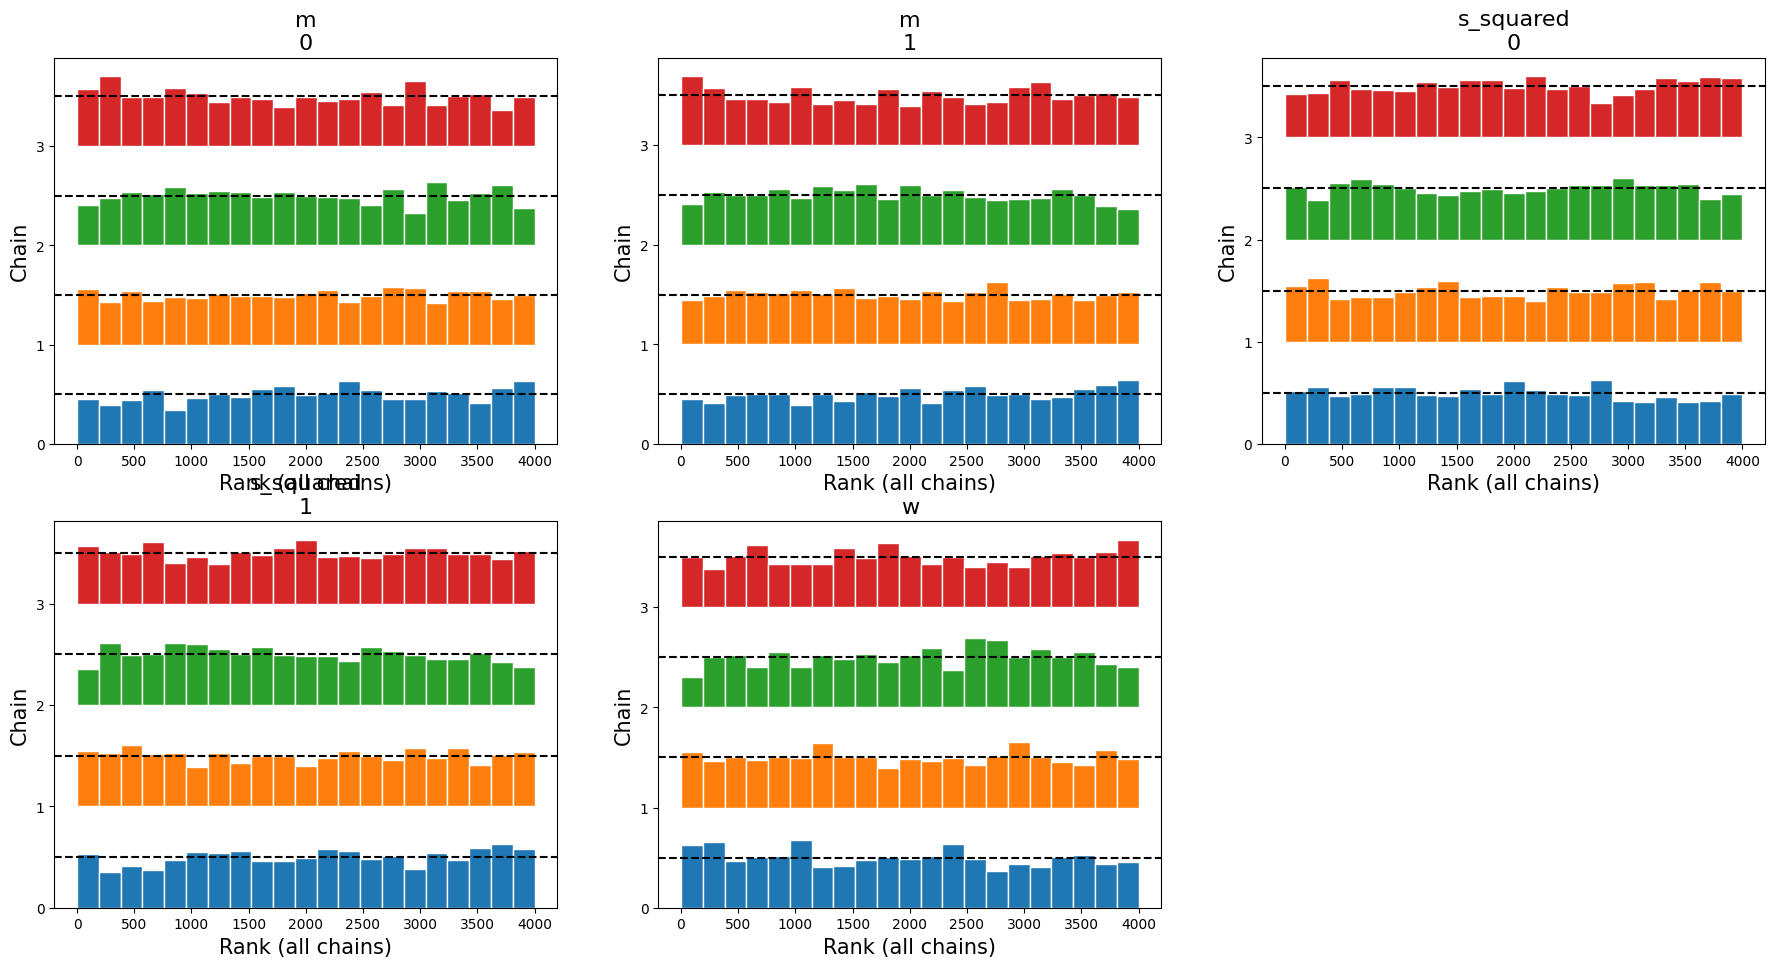

In [26]:
az.plot_rank(inference);

Record your observations. What does the rank plot tell us about how well the sampler worked?

In [16]:
# ENTER YOUR OBSERVATIONS IN YOUR FORUM PRE-CLASS WORKBOOK

**Run this code cell for the posterior pair plot** and record your observations below.

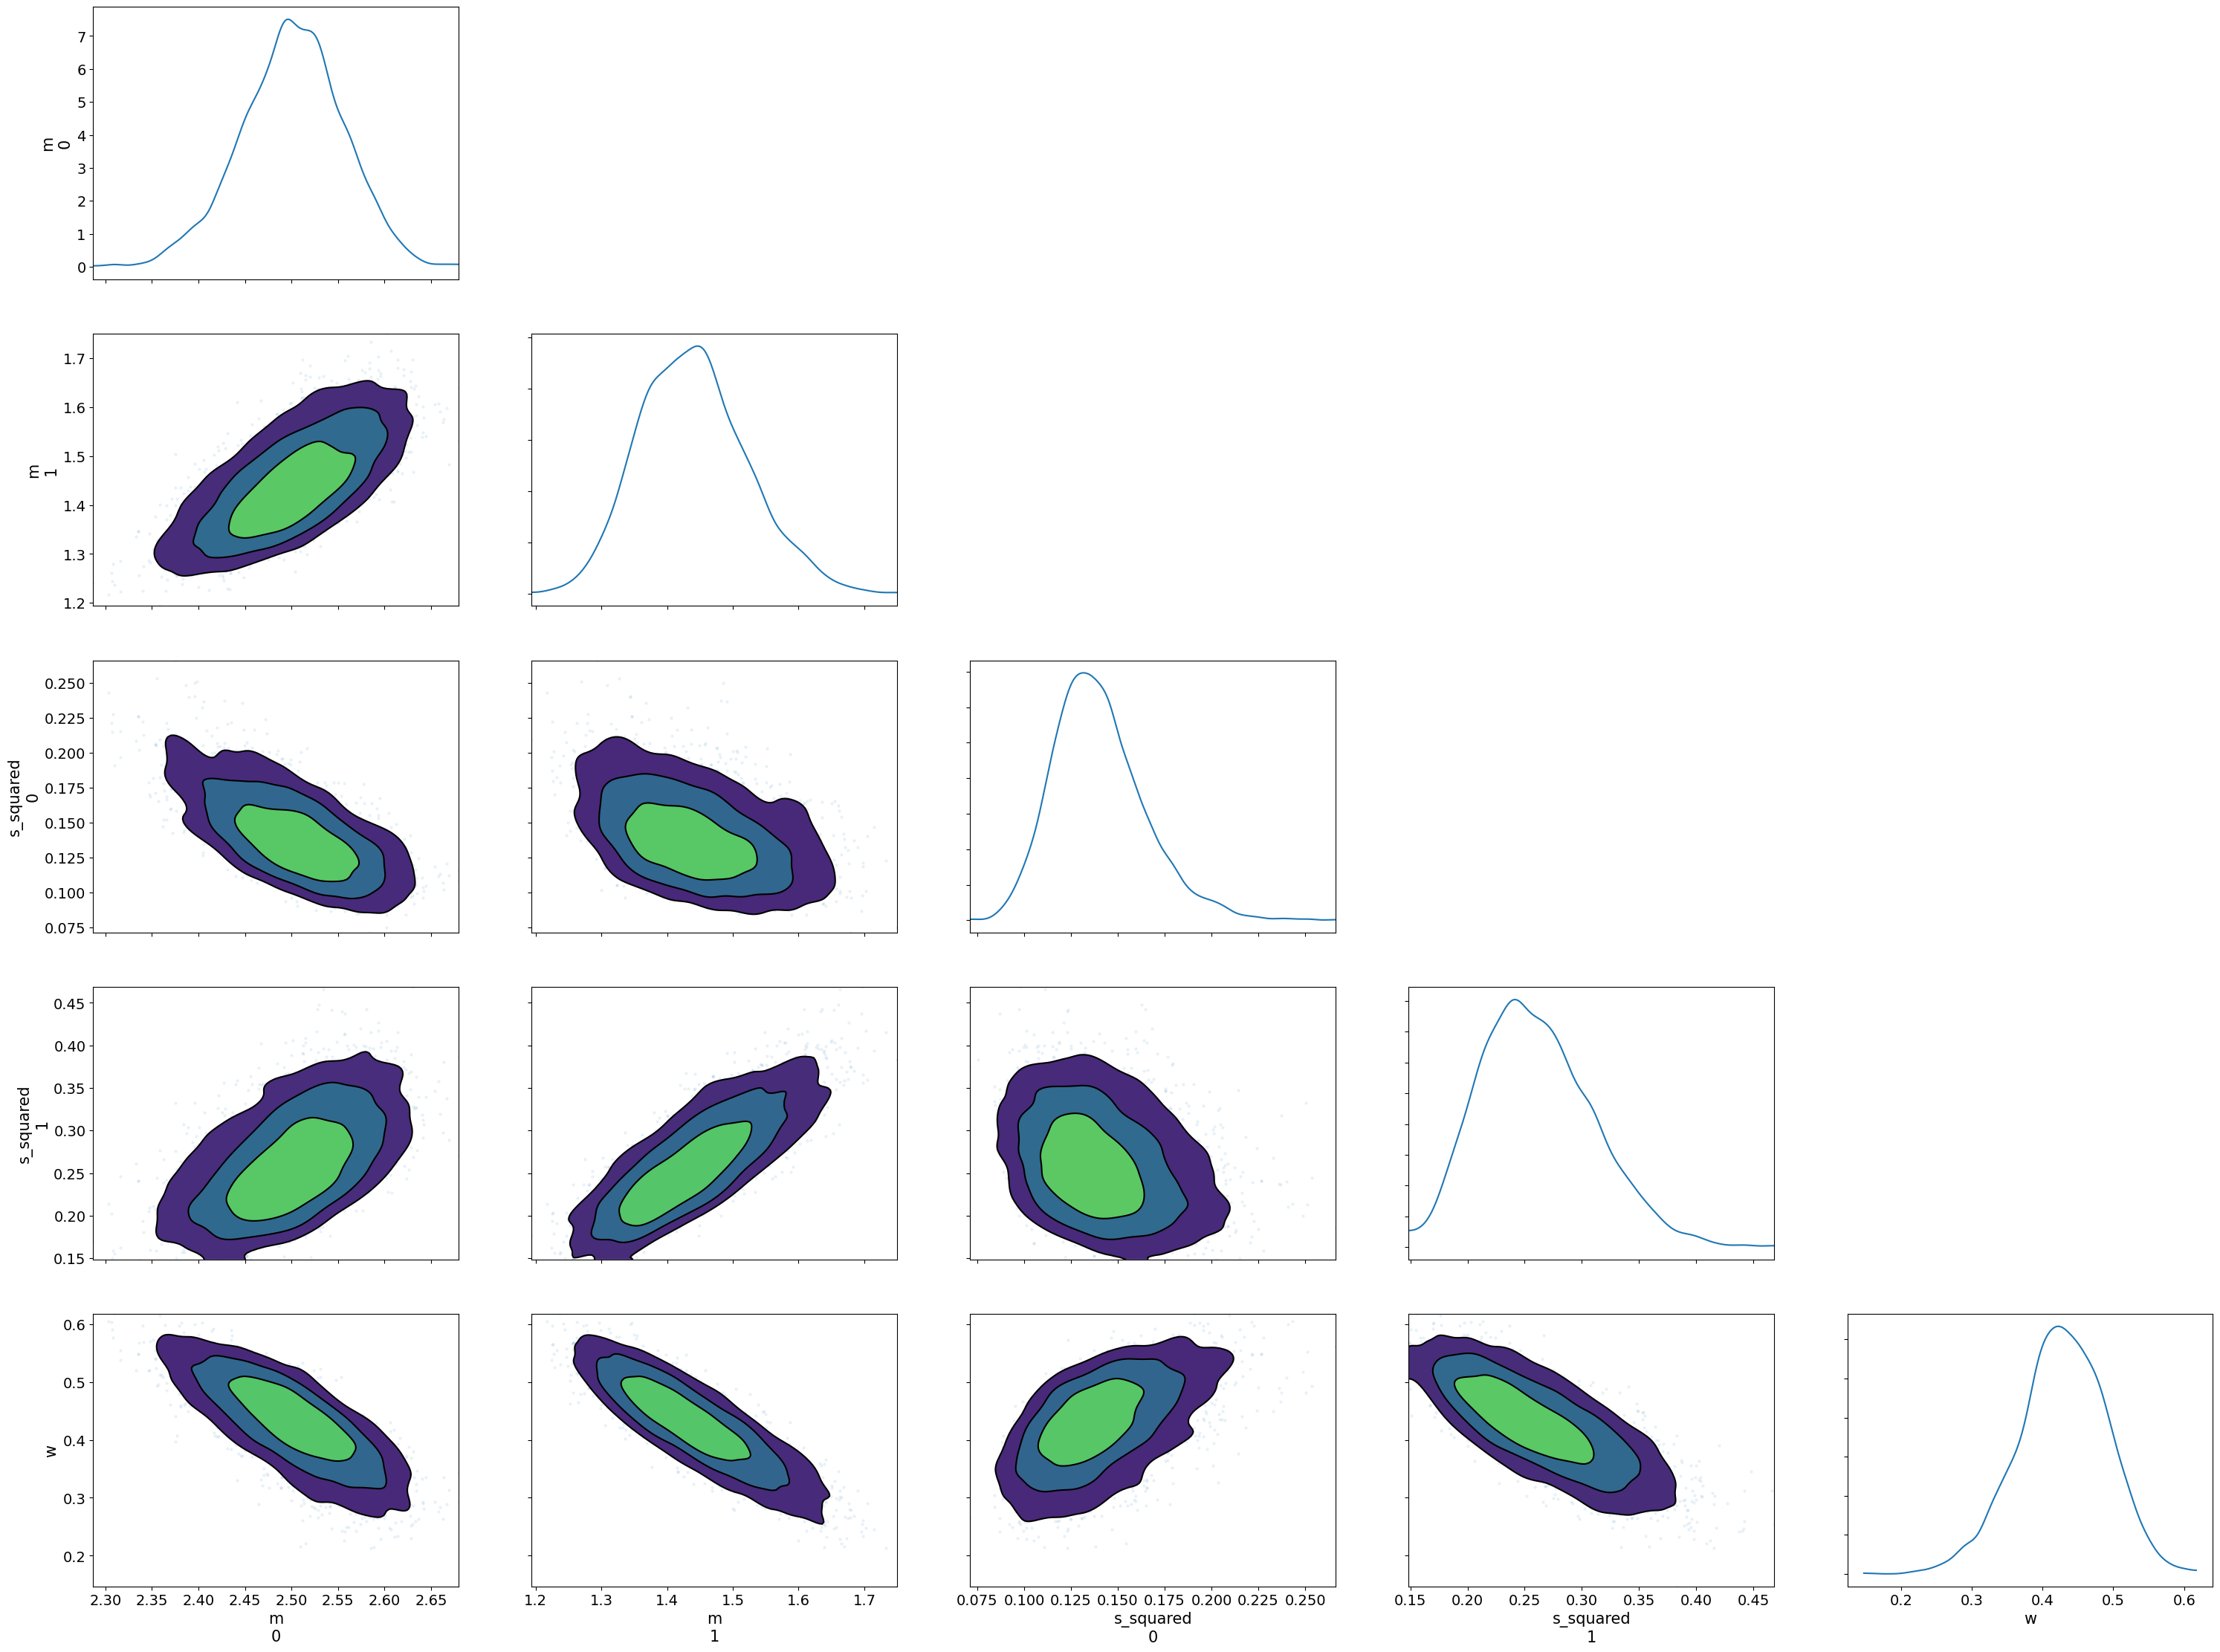

In [27]:
ax = az.plot_pair(
    inference,
    marginals=True,
    kind=["scatter", "kde"],
    scatter_kwargs={"color": "C0", "alpha": 0.1},
    marginal_kwargs={"kind": "kde", "color": "C0"},
    kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}});

What is strange about this posterior distribution? Record any observations about the plots above you think are relevant. We will discuss this at length in class.

In [18]:
# ENTER YOUR OBSERVATIONS IN YOUR FORUM PRE-CLASS WORKBOOK